## Thsi notebook is representing the age and gender detection using CNN

### Data Fetching using kaggle API

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle (3).json
User uploaded file "kaggle (3).json" with length 65 bytes


In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'key'

!pip install kaggle

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [ ]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [ ]:
len(age)

23708

### Crate a dataframe of 3 fetaures [age, gender, imgage]

In [ ]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [ ]:
df.head()

age  gender                                    img
0   37       0  37_0_0_20170117140102778.jpg.chip.jpg
1   24       1  24_1_3_20161220222118601.jpg.chip.jpg
2   25       0  25_0_3_20170119144603197.jpg.chip.jpg
3   37       1  37_1_0_20170104183404469.jpg.chip.jpg
4   41       1  41_1_0_20170104185117127.jpg.chip.jpg

In [ ]:
df.shape

(23708, 3)

In [ ]:
gender_dict = {
    0:'Male',
    1:'Female'
}

### EDA

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

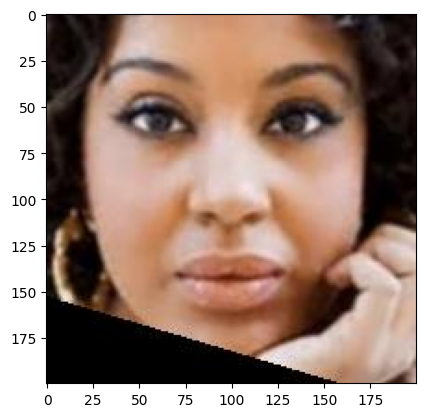

In [ ]:
from PIL import Image

img_path = os.path.join(folder_path, df['img'][25])

img =Image.open(img_path)
plt.imshow(img)

<Axes: ylabel='Density'>

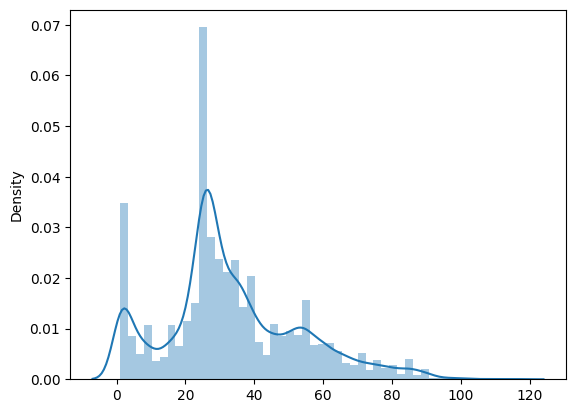

In [ ]:
sns.distplot(x = df['age'])

<Axes: xlabel='gender', ylabel='count'>

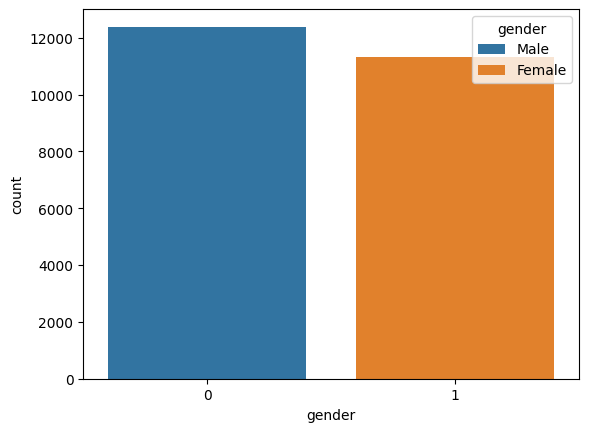

In [ ]:
sns.countplot(x = df['gender'], hue=df['gender'].map(gender_dict))

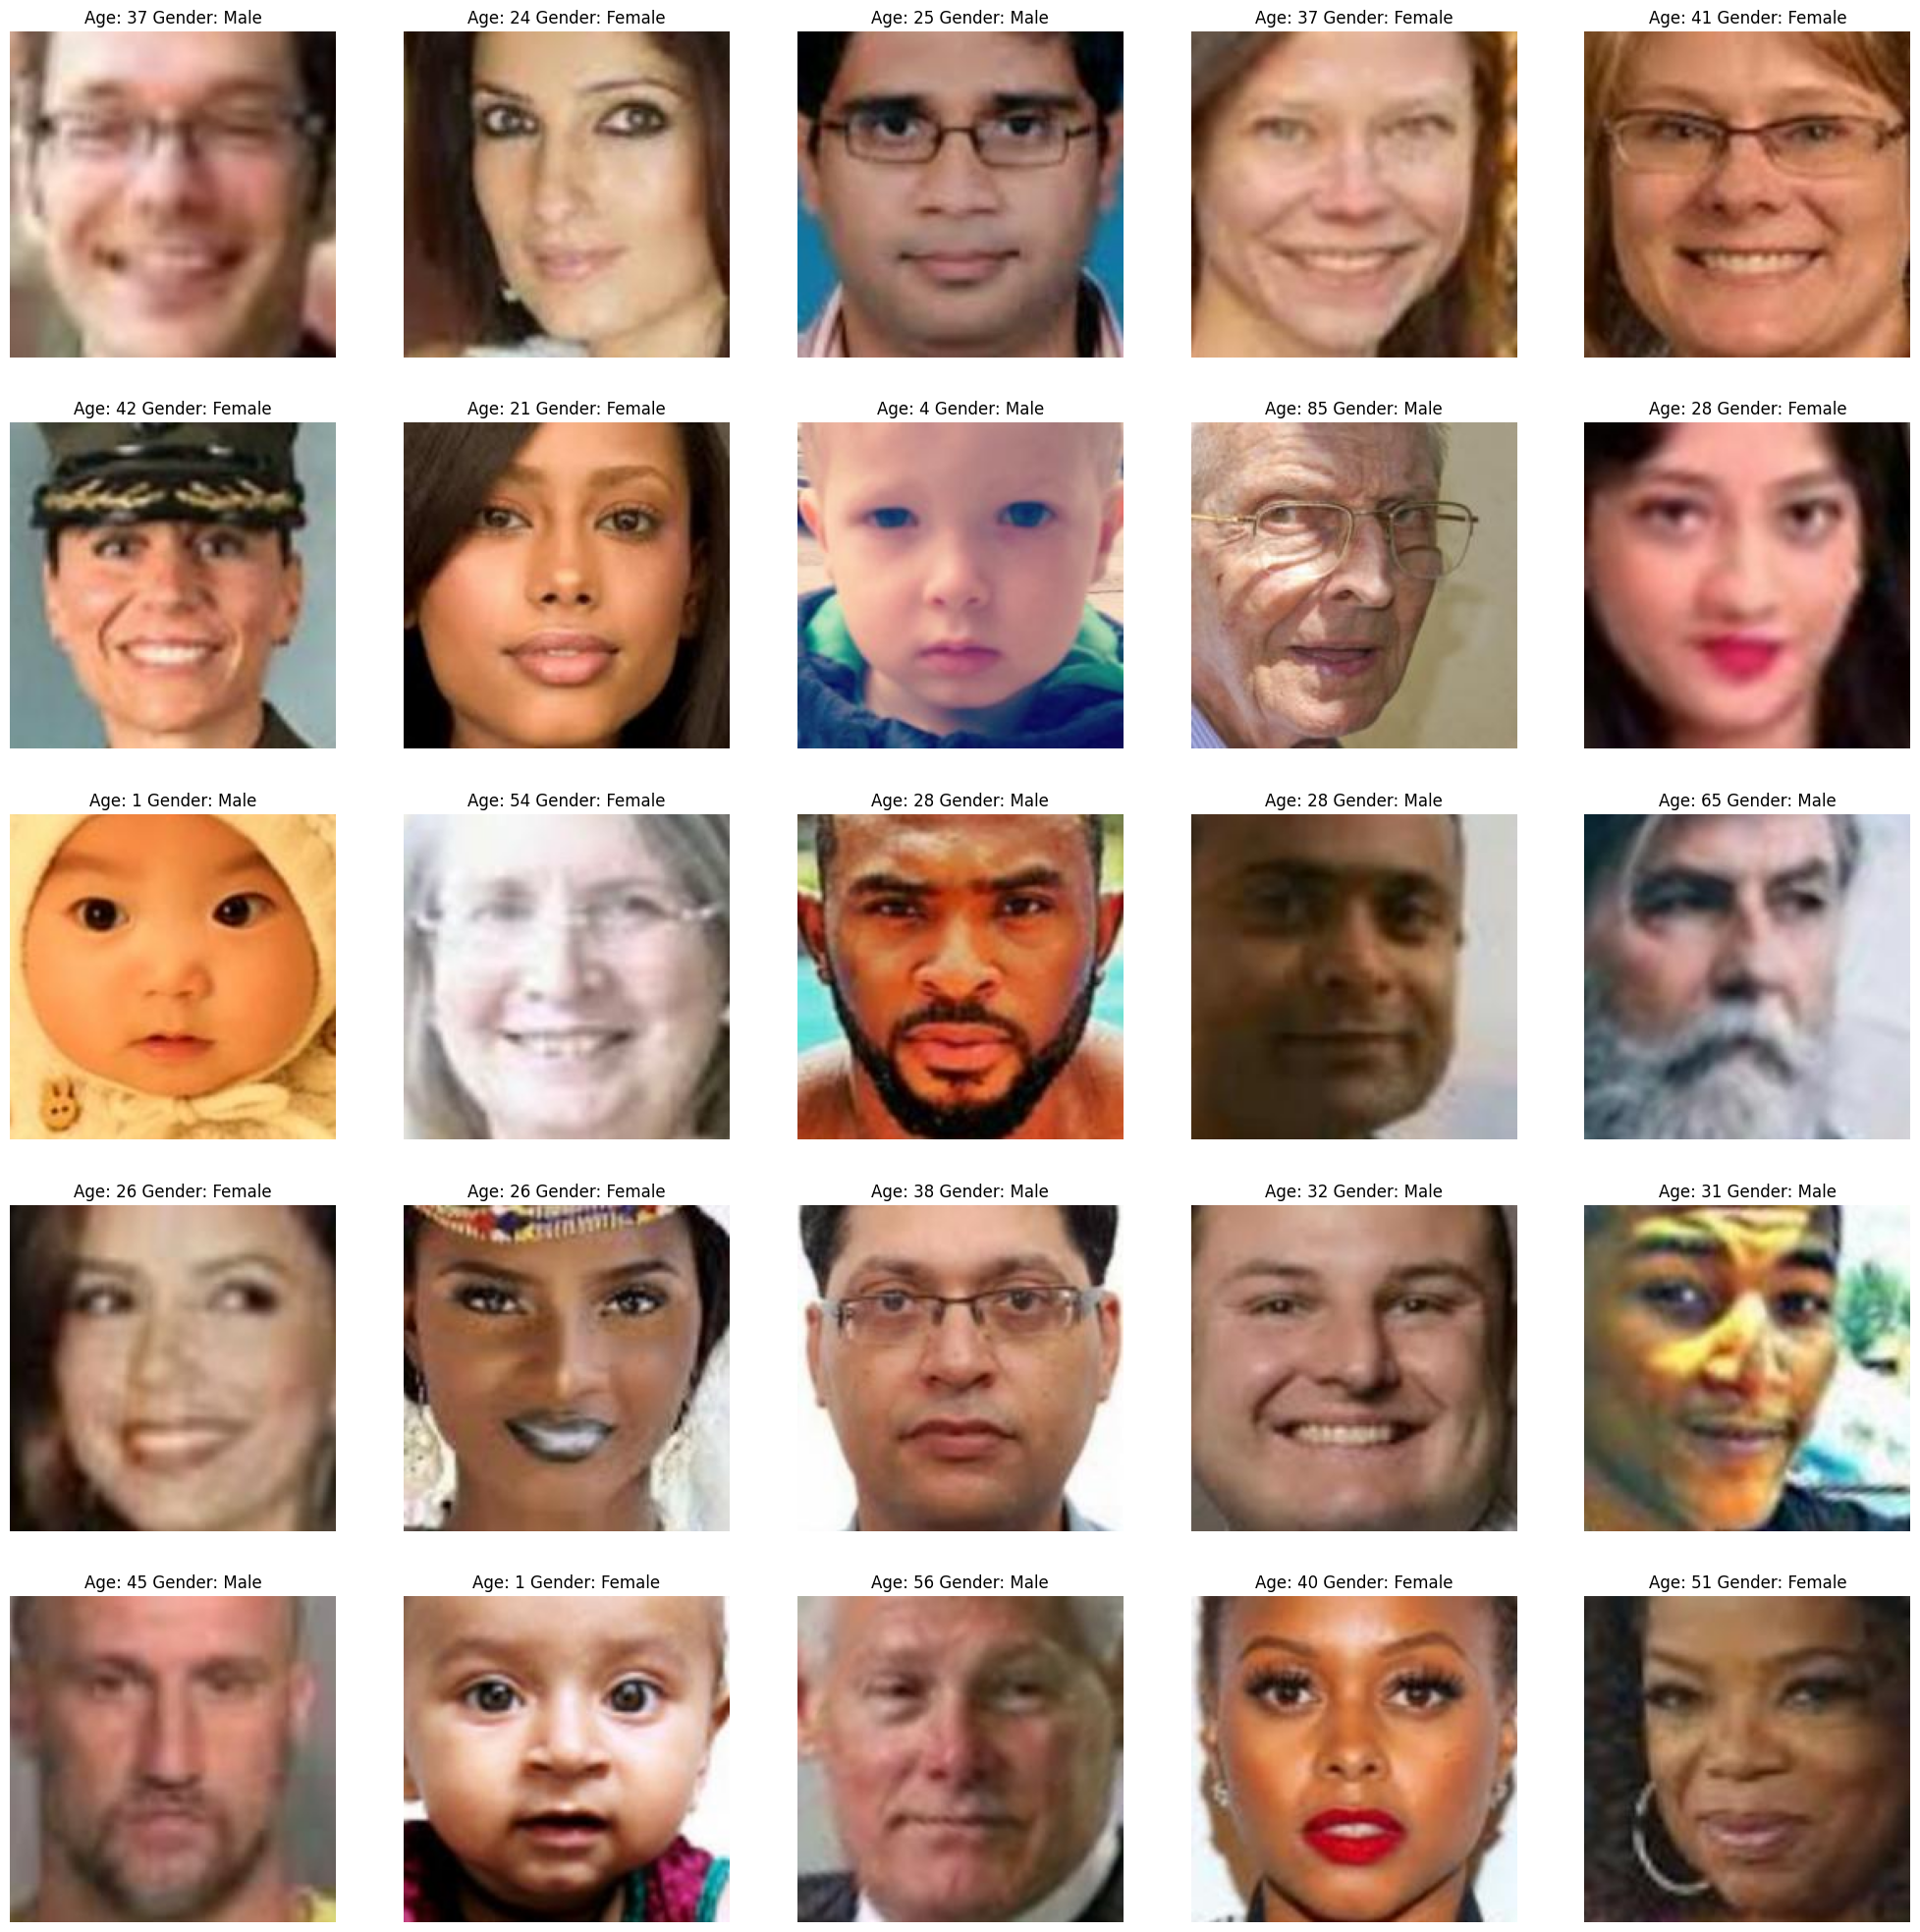

In [ ]:
 plt.figure(figsize=(25,25))
 files = df.iloc[0:25]

 for index,age,gender,img in files.itertuples():
   plt.subplot(5,5,index+1)
   img_path = os.path.join(folder_path,img)
   img = Image.open(img_path)
   plt.imshow(img)
   plt.title(f'Age: {age} Gender: {gender_dict[gender]}')
   plt.axis('off')

### Feature Extraction

In [ ]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [ ]:
def extract_features(image):
  feature = []
  for image in tqdm(image):
    img_path = os.path.join(folder_path,image)
    img = load_img(img_path,color_mode="grayscale")
    img = img.resize((128,128))
    img = np.array(img)
    feature.append(img)

  feature = np.array(feature)
  feature = feature.reshape(len(feature),128,128,1)
  return feature

In [ ]:
X = extract_features(df['img'])

100%|██████████| 23708/23708 [00:19<00:00, 1230.93it/s]


In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128,128,1)

### Model Architecture

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *

In [ ]:
inputs = Input((input_shape))

conv1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(conv1)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(128, kernel_size=(3,3), activation='relu')(conv2)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

flatten = Flatten()(pool3)

dense1 = Dense(128, activation='relu')(flatten)
dense2 = Dense(256,activation='relu')(flatten)

drop1 = Dropout(0.3)(dense1)
drop2 = Dropout(0.3)(dense2)

output1 = Dense(1,activation='linear',name='age')(drop1)
output2 = Dense(1,activation='sigmoid',name='gender')(drop2)

model = Model(inputs=inputs,outputs=[output1,output2])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 124, 124, 64)   │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 122, 122, 128)  │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 61, 61, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 476288)         │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     60,964,992 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │    121,929,984 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │            129 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 182,988,034 (698.04 MB)

 Trainable params: 182,988,034 (698.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'})

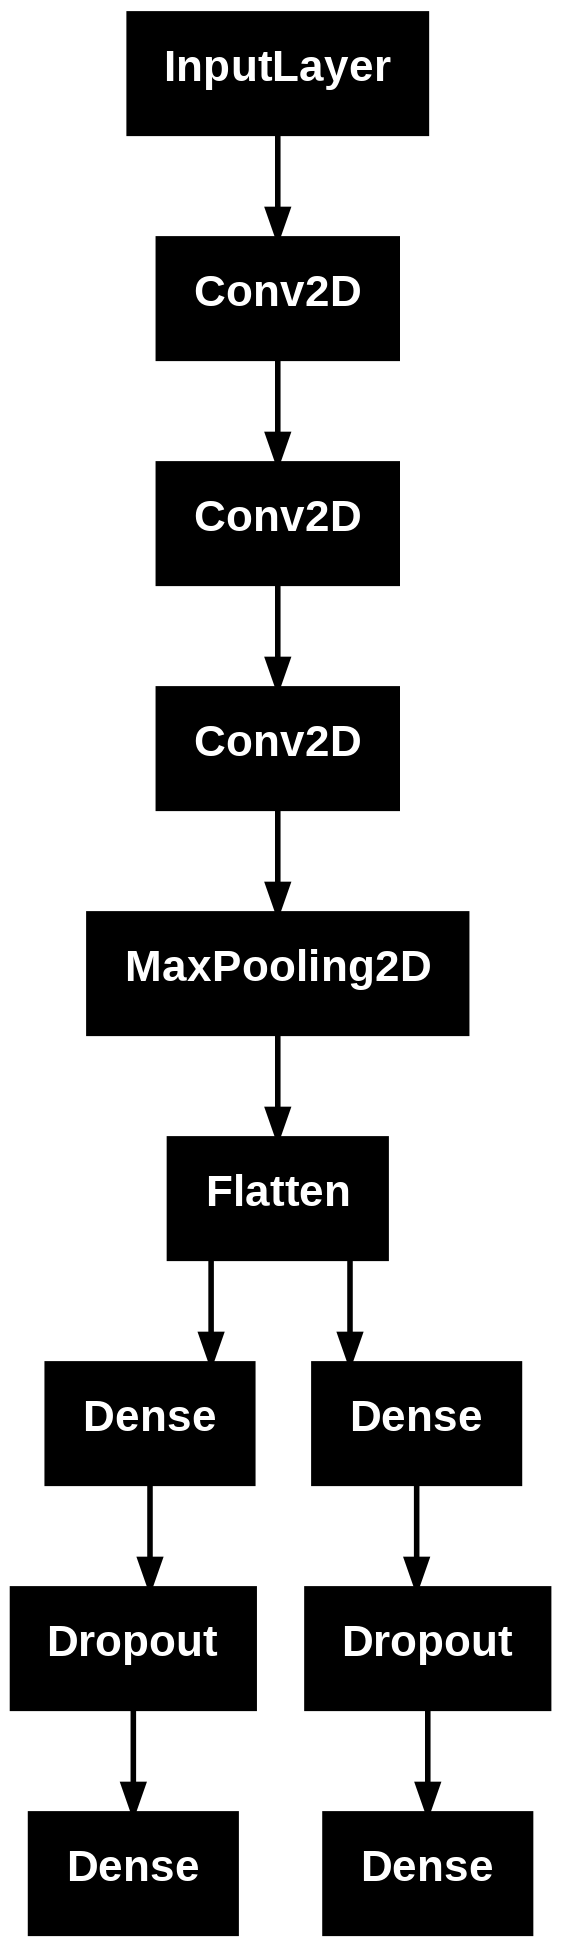

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit(X, [y_age,y_gender], batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 100s 145ms/step - age_loss: 13.9845 - age_mae: 13.9845 - gender_accuracy: 0.7133 - gender_loss: 0.6571 - loss: 14.6416 - val_age_loss: 9.3944 - val_age_mae: 9.3917 - val_gender_accuracy: 0.8385 - val_gender_loss: 0.3507 - val_loss: 9.7415
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 117s 121ms/step - age_loss: 9.5317 - age_mae: 9.5317 - gender_accuracy: 0.8518 - gender_loss: 0.3314 - loss: 9.8630 - val_age_loss: 8.2536 - val_age_mae: 8.2646 - val_gender_accuracy: 0.8720 - val_gender_loss: 0.2837 - val_loss: 8.5477
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 83s 124ms/step - age_loss: 8.2127 - age_mae: 8.2127 - gender_accuracy: 0.8831 - gender_loss: 0.2635 - loss: 8.4763 - val_age_loss: 7.6548 - val_age_mae: 7.6533 - val_gender_accuracy: 0.8806 - val_gender_loss: 0.2784 - val_loss: 7.9301
Epoch 4/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - age_loss: 7.5943 - age_mae: 7.5943 - gender_accuracy: 0.9146 - gender_loss: 0.2053 - loss: 7.7996 - val_age_loss:

### Model Evaluation

**Result for gender**

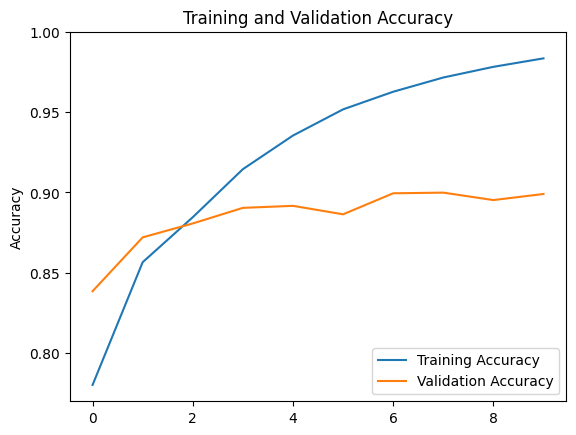

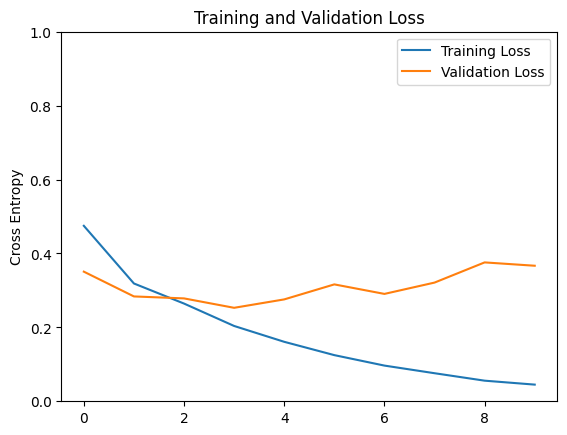

In [ ]:
# Accuracy
acc = history.history['gender_accuracy']
val_acc = history.history['val_gender_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

# Loss
loss = history.history['gender_loss']
val_loss = history.history['val_gender_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.show()

**Result for age**

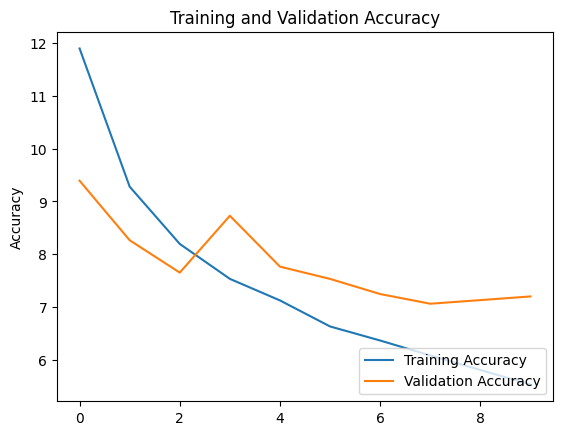

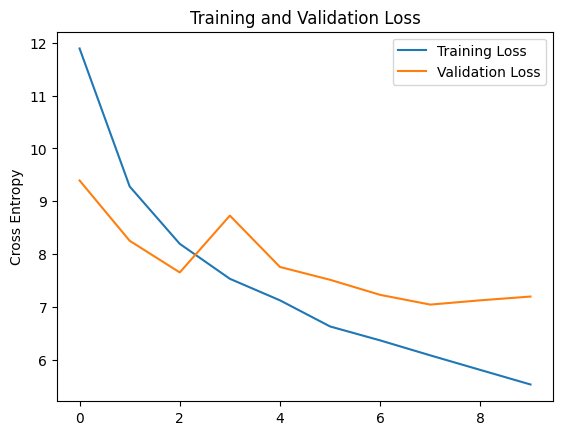

In [ ]:
# Accuracy
acc = history.history['age_mae']
val_acc = history.history['val_age_mae']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Loss
loss = history.history['age_loss']
val_loss = history.history['val_age_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

### Test model


Original Gender: Female Original Age: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Gender: Female Predicted Age: 23


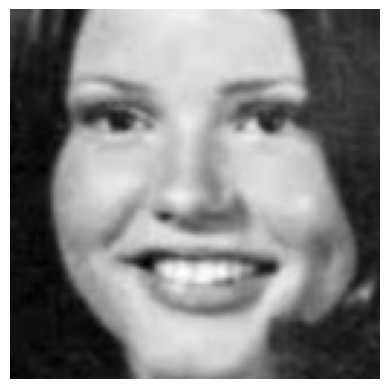

In [ ]:
image_index = 100
print('Original Gender:', gender_dict[y_gender[image_index]], 'Original Age:', y_age[image_index])

pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = int(np.round(pred[1][0][0]))
pred_age = int(np.round(pred[0][0][0]))

print('Predicted Gender:', gender_dict[pred_gender], 'Predicted Age:', pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray')

Original Gender: Female Original Age: 73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Gender: Female Predicted Age: 80


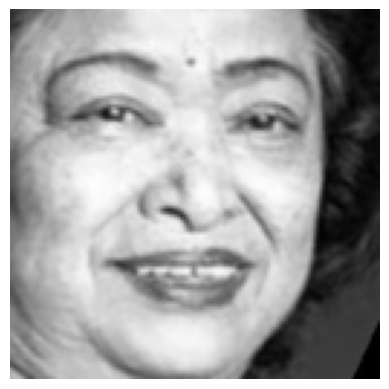

In [ ]:
image_index = 3000
print('Original Gender:', gender_dict[y_gender[image_index]], 'Original Age:', y_age[image_index])

pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = int(np.round(pred[1][0][0]))
pred_age = int(np.round(pred[0][0][0]))

print('Predicted Gender:', gender_dict[pred_gender], 'Predicted Age:', pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray')
plt.show()

**By different images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Gender: Male Predicted Age: 72


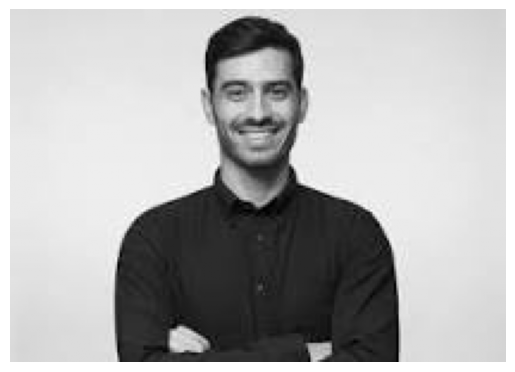

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a new image
image_path = "/content/file.jpeg"  # Change this to your image path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Resize the image to match the model's input shape
img_resized = cv2.resize(img, (128, 128))

# Normalize (if required, e.g., scale pixel values to [0,1])
img_resized = img_resized / 255.0

# Reshape to match model input (1, 128, 128, 1)
img_resized = img_resized.reshape(1, 128, 128, 1)

# Predict age and gender
pred = model.predict(img_resized)
pred_gender = int(np.round(pred[1][0][0]))  # Assuming gender is the second output
pred_age = int(np.round(pred[0][0][0]))  # Assuming age is the first output

# Display results
print('Predicted Gender:', gender_dict[pred_gender], 'Predicted Age:', pred_age)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()


### Model Save

In [ ]:
model.save('age_gender_model.h5')